Author: Sandro Campos, Neven Caplar and the LINCC Frameworks team

Last updated: July 09, 2025

# Problem 4

## Plot folded light curves in ZTF DR23

Let's crossmatch some variable objects of interest with Zwicky Transient Facility (ZTF) DR23 (available at https://data.lsdb.io/#ZTF/ZTF_DR23_(lightcurves)) and plot their folded light curves.

In [1]:
import light_curve as licu
import lsdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
from dask.distributed import Client

ZTF DR23 is provided by IPAC via Amazon S3. To access such data we need to install `s3fs`. We will also install the `light_curve` package, which will later be used to estimate object periods based on their time-domain information.

In [2]:
%pip install s3fs light_curve --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load ZTF with LSDB
ztf_dr23 = lsdb.open_catalog("s3://ipac-irsa-ztf/contributed/dr23/lc/hats")

In [4]:
# Crossmatch with 10 variable locations
variables_csv = """ra,dec,period
94.95546,-24.73952,0.12095
95.30235,-25.27431,0.12248
94.91626,-24.69648,0.12038
95.12418,-25.04329,0.23554
58.83506,-48.79122,0.56335
94.92264,-25.23185,0.07672
94.72086,-25.05767,0.17559
94.97073,-25.13643,0.12048
59.12997,-48.78522,0.11628
94.72086,-25.05767,0.17554
"""
variables_df = pd.read_csv(StringIO(variables_csv)).reset_index()

In ZTF a single astronomical object will be identified by multiple object IDs (due to the fact that objects found in different detectors are treated separately). To make sure we are not missing any relevant detections for each object, we will perform the crossmatch with a large radius (1 arcsec) and a large number of neighbors (20).

In [5]:
result = lsdb.crossmatch(
    variables_df,
    ztf_dr23,
    radius_arcsec=1,
    n_neighbors=20,
    suffixes=["_var", "_ztf_dr23"],
)

We should also filter by "catflags" to remove invalid detections:

In [6]:
# Filter out the invalid ones
result = result.query("lightcurve_ztf_dr23.catflags == 0")
result

,index_var,ra_var,dec_var,period_var,objectid_ztf_dr23,filterid_ztf_dr23,objra_ztf_dr23,objdec_ztf_dr23,lightcurve_ztf_dr23,_dist_arcsec
npartitions=2,,,,,,,,,,
"Order: 3, Pixel: 321",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],int8[pyarrow],float[pyarrow],float[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [...",double[pyarrow]
"Order: 4, Pixel: 1293",...,...,...,...,...,...,...,...,...,...


The following computation takes about ~1min to run on 2 workers:

In [7]:
with Client(n_workers=2, threads_per_worker=1, dashboard_address=":38765") as client:
    result_df = result.compute().sort_values("index_var")

There are matches for 8 out of the 10 variable objects we specified (in fact, 2 for each).

In [8]:
result_df

index_var    ra_var   dec_var  period_var  \
_healpix_29                                                      
1456157018405184225          0  94.95546 -24.73952     0.12095   
1456157018405184225          0  94.95546 -24.73952     0.12095   
1450131236226156835          1  95.30235 -25.27431     0.12248   
1450131236226156835          1  95.30235 -25.27431     0.12248   
1456157750233453047          2  94.91626 -24.69648     0.12038   
1456157750233453047          2  94.91626 -24.69648     0.12038   
1456145241786549427          3  95.12418 -25.04329     0.23554   
1456145241786549427          3  95.12418 -25.04329     0.23554   
1456140633585049253          5  94.92264 -25.23185     0.07672   
1456140633585049253          5  94.92264 -25.23185     0.07672   
1456149791804243835          6  94.72086 -25.05767     0.17559   
1456149791804243835          6  94.72086 -25.05767     0.17559   
1456142101772261065          7  94.97073 -25.13643     0.12048   
1456142101772261065          7  94.97073 -25.13643     0.12048   
1456149791804243835          9  94.72086 -25.05767     0.17554   
1456149791804243835          9  94.72086 -25.05767     0.17554   

                     objectid_ztf_dr23  filterid_ztf_dr23  objra_ztf_dr23  \
_healpix_29                                                                 
1456157018405184225    258208100006442                  2       94.955467   
1456157018405184225    258108100009037                  1       94.955482   
1450131236226156835    258207300001033                  2       95.302368   
1450131236226156835    258107300000583                  1        95.30233   
1456157750233453047    258208100005846                  2        94.91626   
1456157750233453047    258108100003289                  1        94.91626   
1456145241786549427    258208100010900                  2       95.124191   
1456145241786549427    258108100006202                  1       95.124191   
1456140633585049253    258108400000373                  1       94.922646   
1456140633585049253    258208400035461                  2       94.922623   
1456149791804243835    258108100006348                  1       94.720856   
1456149791804243835    258208100011136                  2       94.720848   
1456142101772261065    258208100024003                  2       94.970718   
1456142101772261065    258108100007040                  1       94.970779   
1456149791804243835    258108100006348                  1       94.720856   
1456149791804243835    258208100011136                  2       94.720848   

                     objdec_ztf_dr23  \
_healpix_29                            
1456157018405184225       -24.739527   
1456157018405184225       -24.739544   
1450131236226156835        -25.27429   
1450131236226156835       -25.274321   
1456157750233453047       -24.696495   
1456157750233453047       -24.696501   
1456145241786549427       -25.043276   
1456145241786549427       -25.043272   
1456140633585049253       -25.231831   
1456140633585049253       -25.231833   
1456149791804243835       -25.057667   
1456149791804243835       -25.057661   
1456142101772261065       -25.136433   
1456142101772261065       -25.136465   
1456149791804243835       -25.057667   
1456149791804243835       -25.057661   

                                                   lightcurve_ztf_dr23  \
_healpix_29                                                              
1456157018405184225  [{hmjd: 58397.52198, mag: 18.0459, magerr: 0.0...   
1456157018405184225  [{hmjd: 58423.44057, mag: 19.25569, magerr: 0....   
1450131236226156835  [{hmjd: 58397.52194, mag: 18.846132, magerr: 0...   
1450131236226156835  [{hmjd: 58426.44323, mag: 19.634962, magerr: 0...   
1456157750233453047  [{hmjd: 58397.52198, mag: 17.228245, magerr: 0...   
1456157750233453047  [{hmjd: 58423.44057, mag: 17.41291, magerr: 0....   
1456145241786549427  [{hmjd: 58397.52196, mag: 15.731258, magerr: 0...   
1456145241786549427  [{hmjd: 58423.44054, mag: 15.66658, m

Each object match has light curve data in one band - either "g" (`filterid_ztf_dr23` == 1) or "r" (`filterid_ztf_dr23` == 2).

In [9]:
# Mapping of filter IDs to band names
FILTER_ID_TO_BAND = {1: "g", 2: "r", 3: "i"}

# Mapping of band names to colors for plotting
COLORS = {"g": "green", "r": "red", "i": "purple"}


def estimate_period(approx_period, hmjds, mags):
    """Find the period for a certain lightcurve based on an estimate"""
    freqs = (
        2.0 * np.pi * np.linspace(0.999 / approx_period, 1.001 / approx_period, 10_000)
    )
    t = np.asarray(hmjds, dtype=np.float32)
    mags = np.asarray(mags, dtype=np.float32)
    _, sort_index = np.unique(t, return_index=True)
    return licu.Periodogram(fast=False, freqs=freqs)(t[sort_index], mags[sort_index])[0]

In [10]:
def plot_lightcurves(ax, group):
    """Plot lightcurves for the matches of a variable object"""
    all_lcs = []
    for _, row in group.iterrows():
        lc = row.lightcurve_ztf_dr23
        period = estimate_period(row.period_var, lc.hmjd, lc.mag)
        # Compute phase
        lc = lc.assign(phase=(lc.hmjd - lc.hmjd.loc[lc.mag.idxmax()]) % period / period)
        band = FILTER_ID_TO_BAND[row.filterid_ztf_dr23]
        label = f"{band}, ZTF_ID={row.objectid_ztf_dr23}, period={period:.7f}"
        # Plot each row's lightcurve (label only for phase plot to avoid duplicates)
        plot_mag_scale(
            ax[0], lc, "mag", "magerr", band, None, x_name="hmjd", x_label="HMJD"
        )
        plot_mag_scale(
            ax[1], lc, "mag", "magerr", band, label, x_name="phase", x_label="Phase"
        )
    # Add legend to the figure
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.02), ncol=3, fontsize=12)


def plot_mag_scale(ax, lc, mag_col, magerr_col, band, legend, x_name, x_label):
    """Plot lightcurve in magnitude scale"""
    mag = lc[mag_col]
    magErr = lc[magerr_col]
    ax.errorbar(
        lc[x_name],
        mag,
        magErr,
        fmt="o",
        label=legend,
        color=COLORS[band],
        alpha=1,
        markersize=5,
        capsize=3,
        elinewidth=1,
    )
    if x_label == "Phase":
        ax.set_xlim([0, 1])  # Fix the axis limits
    ax.set_xlabel(x_label)
    ax.set_ylabel("Magnitude")

Finally, let's plot them. Each figure that follows has:
- On the left, the original light curves for the two matches.
- On the right, the corresponding folded light curves.
- On the bottom, a legend specifying the objects they correspond to and their estimated period.

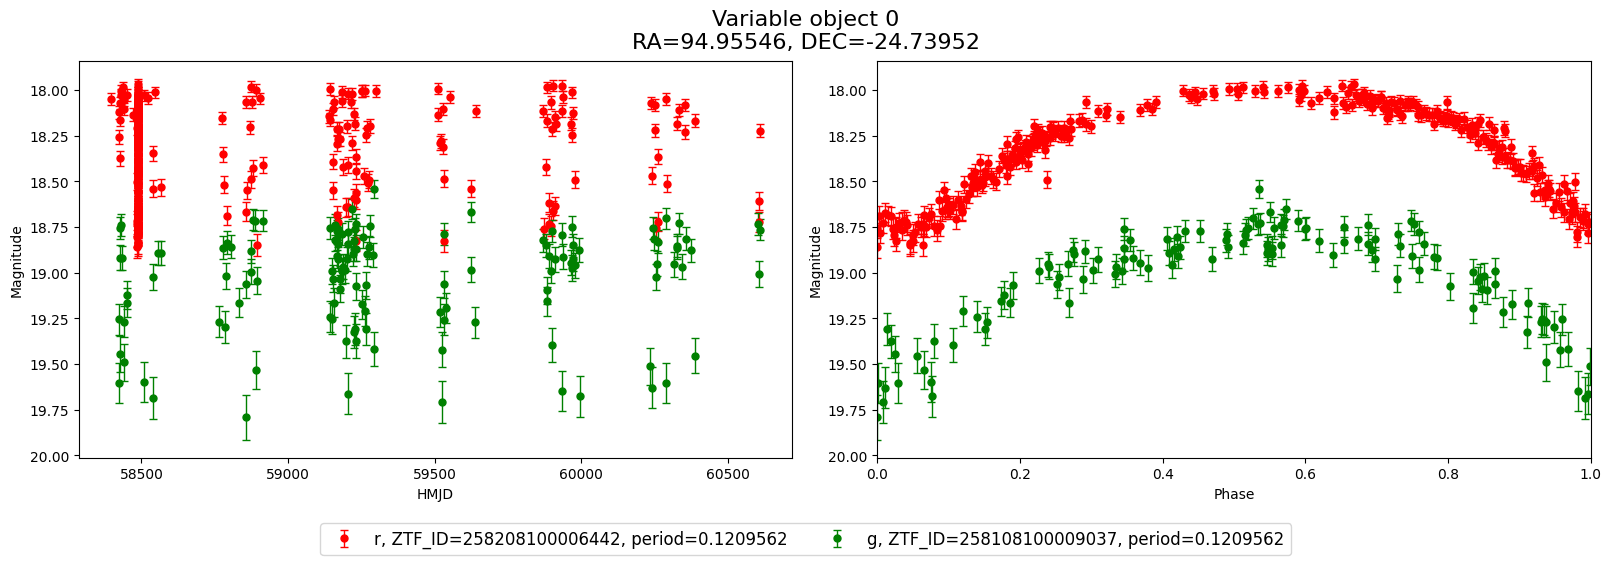

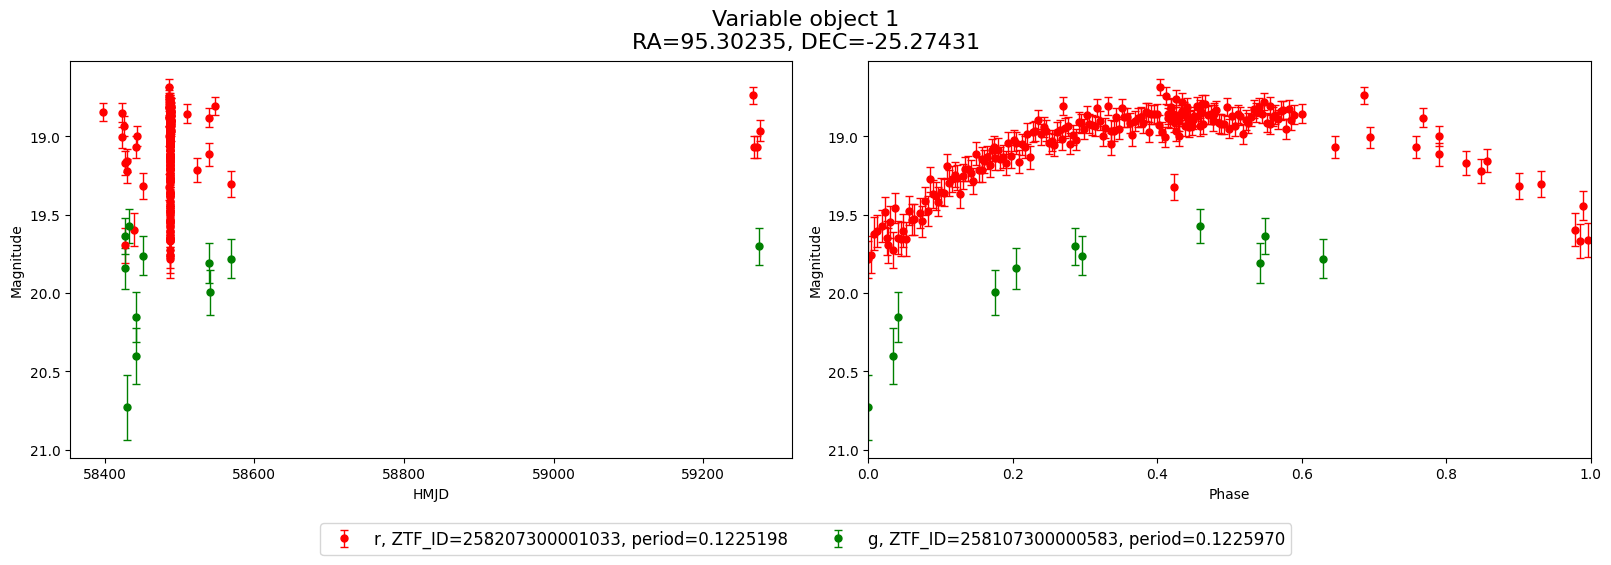

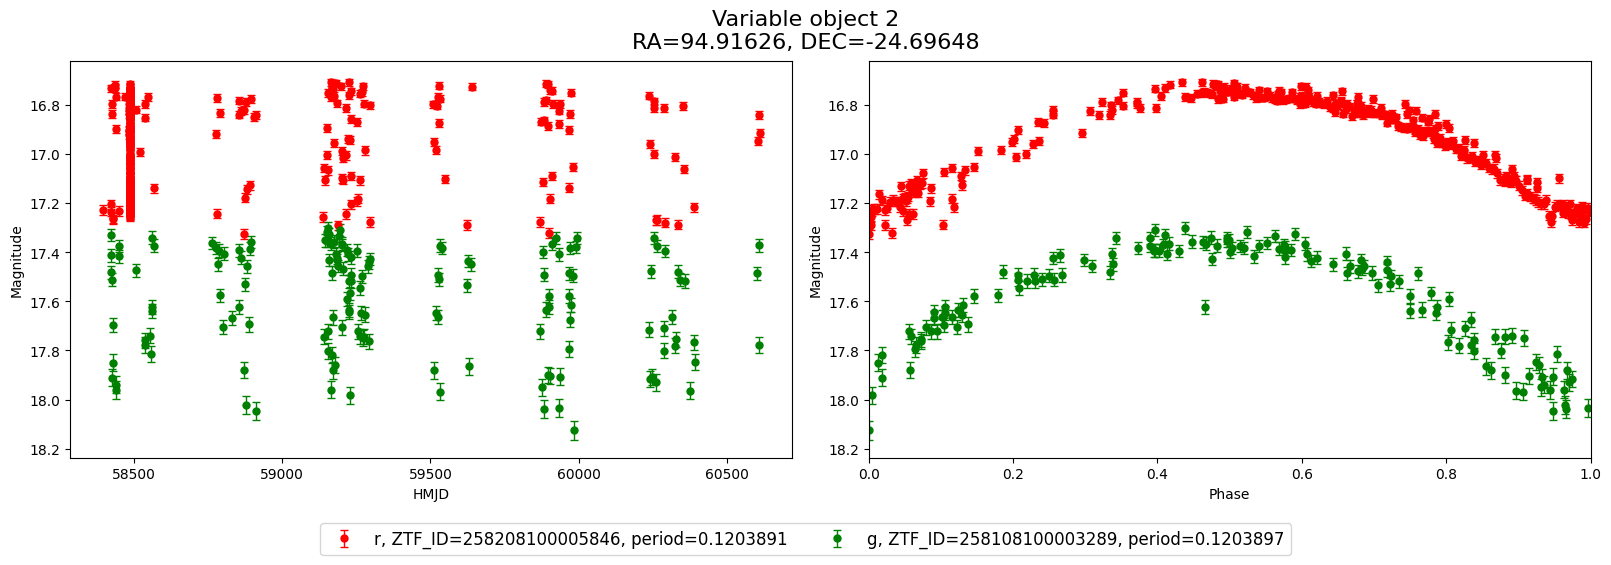

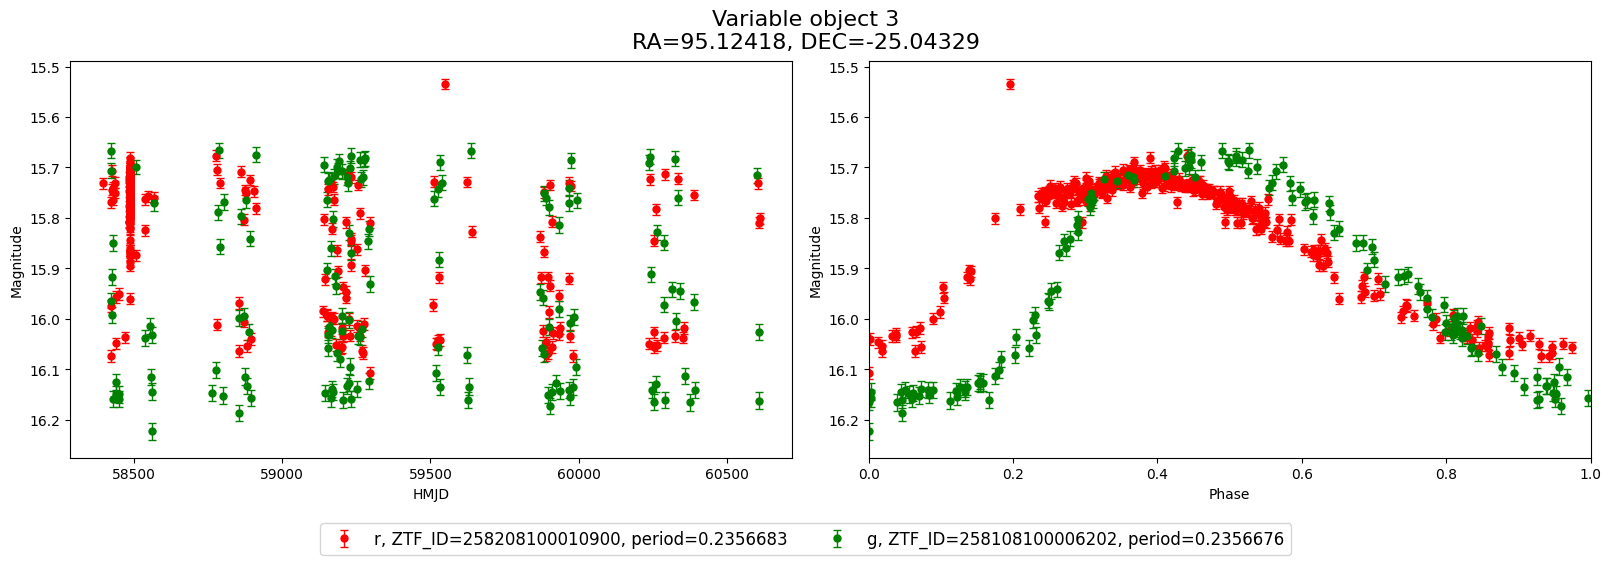

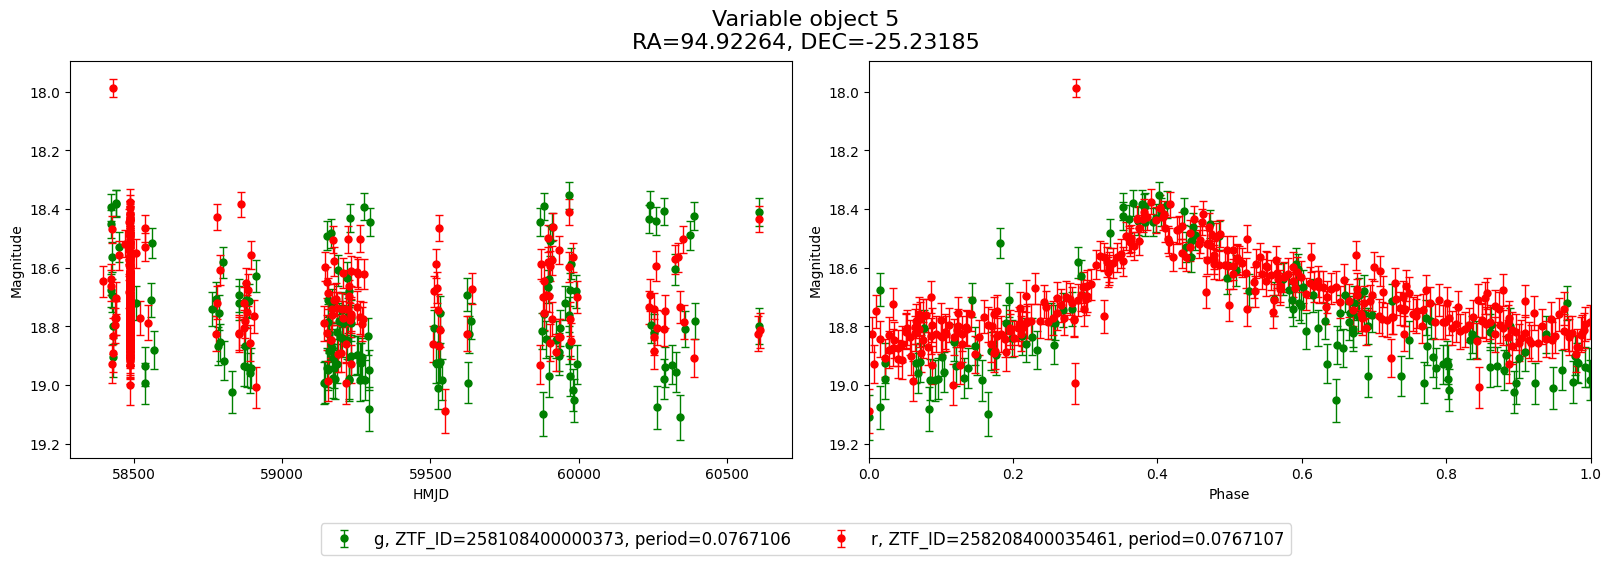

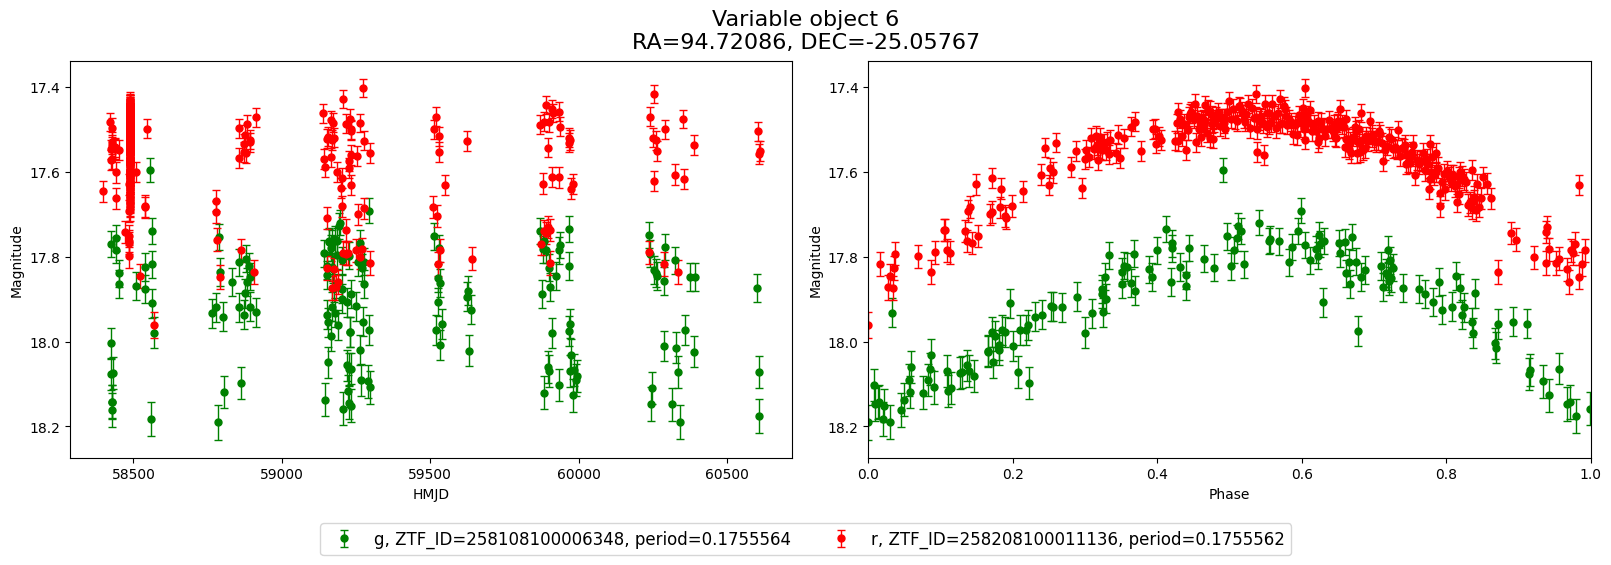

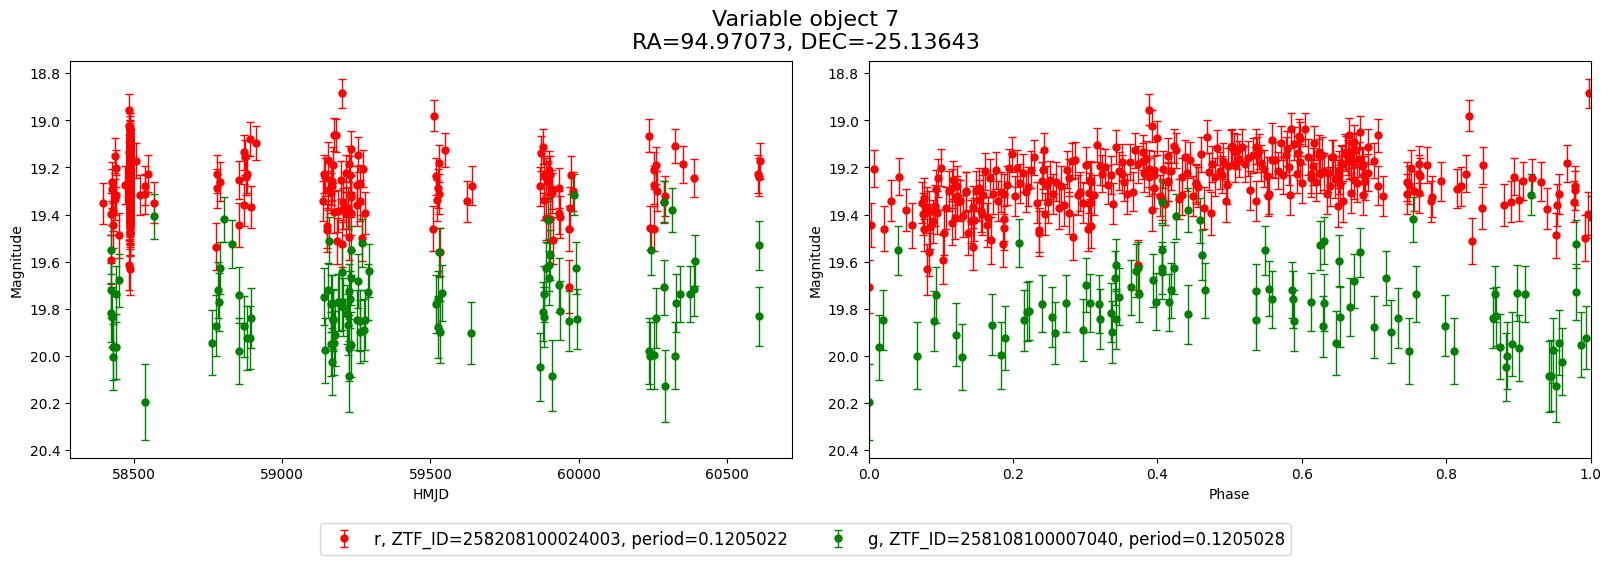

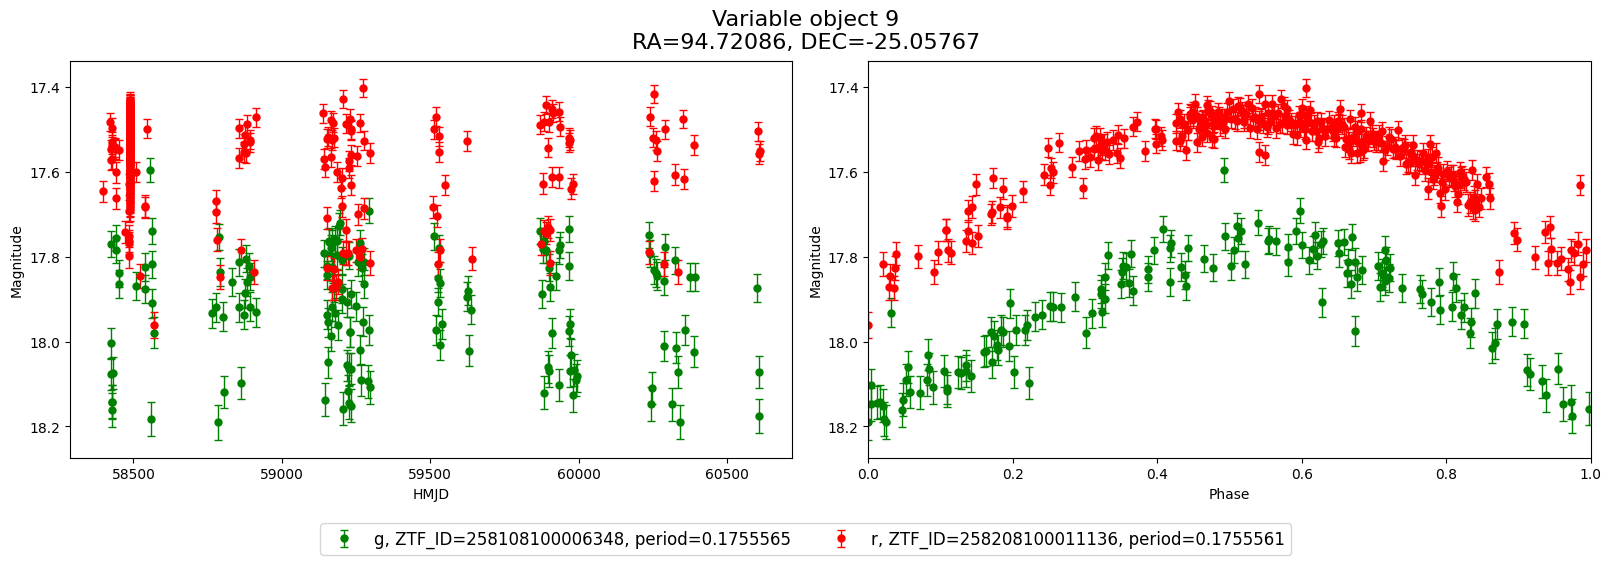

In [11]:
for index_var, group in result_df.groupby("index_var"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), constrained_layout=True)
    period = plot_lightcurves(ax, group)
    row = group.iloc[0]
    # Magnitudes are plotted with brighter objects lower
    ax[0].invert_yaxis()
    ax[1].invert_yaxis()
    # Set figure titles
    title = f"Variable object {row.index_var}"
    title += f"\nRA={row.ra_var}, DEC={row.dec_var}"
    fig.suptitle(title, fontsize=16)
    plt.show()